# Test reduced variance of gene expression data

**Motivation**: When we plotted a volcano plot of the E-GEOD-51409 array experiment using the [actual data](volcano_original_data_E-GEOD-51409_example_adjp.png) and the [experiment-level simulated data](volcano_simulated_data_E-GEOD-51409_example_adjp.png), we found that the simulated data had reduced variance based on the squished log fold chance values.

**Question:** What is causing the reduced variance in the simulated data? Is this reduced variance 1) the result of the latent space shifting (see [simulate_compendium module](../functions/generate_data_parallel.py) or 2) a property of the variational autoencoder (VAE) algorithm?

This notebook aims to answer this question by performing 2 short experiments. In the first experiment, we test the effect of the latent space shifting and hold the VAE constant. In the second experiment, we test the effect of the VAE and hold the shifting constant.

In [1]:
%load_ext autoreload
%autoreload 2

import os
import ast
import sys
import pandas as pd
import numpy as np
import random

sys.path.append("../")
from functions import utils

import warnings
warnings.filterwarnings(action='ignore')

from numpy.random import seed
randomState = 123
seed(randomState)

In [2]:
# Read in config variables
# Pick one of the Pseudomonas config files
# Doesn't matter if sample or experiment level for this notebook
base_dir = os.path.abspath(os.path.join(os.getcwd(),"../"))
config_file = os.path.abspath(os.path.join(base_dir,
                                           "configs", 
                                           "config_Pa_sample_limma.tsv"))
params = utils.read_config(config_file)

In [3]:
# Load parameters
local_dir = params["local_dir"]

## Experiment 1

In this experiment we want to test the effect of the linear shift on the gene expression variance. 

To do this we will compare the distribution of the gene variance in the simulated dataset generated using the [sample-level simulation](../Pseudomonas/Pseudomonas_sample_lvl_sim.ipynb), which does *not* perform a linear shift, versus the simulated dataset generated using the [experiment-level simulation](../Pseudomonas/Pseudomonas_experiment_lvl_sim.ipynb), which does perform a linear shift. Both simulations use the VAE, so this factor is held constant and the variable we are testing is the latent space shift.


In [4]:
# Load datasets created from the two different simulations
no_shift_file = os.path.join(
    local_dir,
    "experiment_simulated",
    "Pseudomonas_sample_lvl_sim",
    "Experiment_1_0.txt.xz")

shift_file = os.path.join(
    local_dir,
    "partition_simulated",
    "Pseudomonas_experiment_lvl_sim",
    "Partition_1_0.txt.xz")

In [5]:
# Read in datasets
no_shift_data = pd.read_table(
    no_shift_file,
    header=0,
    index_col=0,
    sep='\t')

shift_data = pd.read_table(
    shift_file,
    header=0,
    index_col=0,
    sep='\t')

print(no_shift_data.shape)
no_shift_data.head()

(6000, 5549)


,0,1,2,3,4,5,6,7,8,9,...,5539,5540,5541,5542,5543,5544,5545,5546,5547,5548
0,0.524893,0.520740,0.437727,0.503881,0.381821,0.447112,0.322690,0.448206,0.418196,0.214085,...,0.452529,0.469783,0.541290,0.466450,0.490254,0.386582,0.461289,0.511527,0.703659,0.681971
1,0.637191,0.642319,0.469714,0.620168,0.410521,0.380123,0.317894,0.591224,0.540865,0.178979,...,0.375130,0.558720,0.566576,0.531656,0.597858,0.236743,0.505707,0.538541,0.672413,0.678159
2,0.579925,0.589930,0.416886,0.573579,0.343545,0.375572,0.451579,0.498441,0.447957,0.211432,...,0.375602,0.555890,0.480001,0.472683,0.514420,0.279362,0.499572,0.444599,0.525686,0.503861
3,0.577142,0.594846,0.424863,0.555629,0.377089,0.432764,0.404817,0.489170,0.426781,0.202450,...,0.388163,0.525106,0.514754,0.489396,0.526913,0.257425,0.458029,0.440186,0.618535,0.605404
4,0.564590,0.610596,0.393297,0.505810,0.393261,0.374961,0.289844,0.525382,0.483766,0.237359,...,0.349643,0.567037,0.546622,0.510529,0.569359,0.212567,0.565946,0.432346,0.704998,0.729451


In [6]:
print(shift_data.shape)
shift_data.head()

(5614, 5549)


,PA0001,PA0002,PA0003,PA0004,PA0005,PA0006,PA0007,PA0008,PA0009,PA0010,...,PA5561,PA5562,PA5563,PA5564,PA5565,PA5566,PA5567,PA5568,PA5569,PA5570
0,0.634455,0.625769,0.503150,0.674790,0.382556,0.516121,0.526702,0.462050,0.387196,0.312756,...,0.445861,0.555707,0.637891,0.435771,0.534148,0.229338,0.271221,0.404903,0.612096,0.702427
1,0.627358,0.627293,0.503486,0.683220,0.385825,0.530789,0.518780,0.440679,0.376925,0.308939,...,0.463916,0.561225,0.635780,0.443964,0.531261,0.240135,0.291886,0.421289,0.606031,0.689835
2,0.607895,0.611168,0.500100,0.678058,0.399754,0.536595,0.496203,0.418799,0.374722,0.321040,...,0.447529,0.562199,0.629054,0.429816,0.482418,0.253325,0.274026,0.431030,0.595983,0.674272
3,0.592802,0.608616,0.497515,0.670645,0.387558,0.561180,0.531733,0.386082,0.365965,0.326617,...,0.483379,0.545276,0.604272,0.434330,0.477991,0.255534,0.281843,0.444738,0.588230,0.668904
4,0.733307,0.769780,0.388229,0.713862,0.583696,0.464944,0.850785,0.538054,0.583613,0.161236,...,0.319624,0.585686,0.527095,0.626989,0.713613,0.101546,0.355004,0.532085,0.714445,0.669498


In [7]:
# Get variance per gene
var_no_shift = no_shift_data.var(axis=0)
var_shift = shift_data.var(axis=0)

In [9]:
df = pd.DataFrame(list(zip(var_no_shift, var_shift)), 
               columns =['not shifted', 'shifted']) 
df.head()

,not shifted,shifted
0,0.006284,0.017545
1,0.003596,0.016746
2,0.003598,0.022712
3,0.005539,0.016824
4,0.003882,0.014782


In [10]:
# Plot distribution of variances using no shifted data and shifted data
boxplot = df.boxplot(column=['not shifted', 'shifted'])

**Observations:** We can see that compared to the not shifted compendium, the shifted compendium has a slightly larger variance. This makes sense given that we are shifting our samples in the latent space. The samples were shifted randomly to a new location in the latent space. Theoretically, we could get a smaller variance using the shifted approach *if* all the shifts happen to compress the samples together, however the likelihood of this happening is very rare.

## Experiment 2

In this experiment we want to test the effect of the VAE on the gene expression variance. 

To do this we will compare the distribution of the gene variance in the [original dataset](../Pseudomonas/data/input/train_set_normalized.pcl), which does not use the VAE, versus simulated dataset generated using the [sample-level simulation](../Pseudomonas/Pseudomonas_sample_lvl_sim.ipynb), which uses the learned latent space of the VAE to simulate new data. Neither dataset uses the shifting, so this factor is held constant and the variable we are testing is the application of the VAE.

In [11]:
# Load datasets from the actual data and the simulate data
no_vae_file = os.path.join(
    base_dir,
    "Pseudomonas",
    "data",
    "input",
    "train_set_normalized.pcl")

vae_file = os.path.join(
    local_dir,
    "partition_simulated",
    "Pseudomonas_experiment_lvl_sim",
    "Partition_1_0.txt.xz")

In [12]:
# Read in datasets
no_vae_data = pd.read_table(
    no_vae_file,
    header=0,
    index_col=0,
    sep='\t').T

vae_data = shift_data

print(no_vae_data.shape)
no_vae_data.head()

(950, 5549)


Gene_symbol,PA0001,PA0002,PA0003,PA0004,PA0005,PA0006,PA0007,PA0008,PA0009,PA0010,...,PA5561,PA5562,PA5563,PA5564,PA5565,PA5566,PA5567,PA5568,PA5569,PA5570
05_PA14000-4-2_5-10-07_S2.CEL,0.853357,0.725280,0.640617,0.811465,0.694460,0.533958,0.158865,0.889579,0.884945,0.176558,...,0.466871,0.702785,0.790965,0.893249,0.789939,0.164157,0.970470,0.887472,0.900484,0.880012
54375-4-05.CEL,0.778790,0.767873,0.614859,0.907865,0.398800,0.460849,0.113876,0.761351,0.801740,0.222709,...,0.352020,0.694387,0.733186,0.639074,0.681204,0.110301,0.619554,0.747656,0.749893,0.805374
AKGlu_plus_nt_7-8-09_s1.CEL,0.789155,0.729508,0.725913,0.718989,0.530160,0.466327,0.079507,0.731643,0.827707,0.241847,...,0.392405,0.700352,0.773422,0.791118,0.931585,0.172570,0.797148,0.753785,0.856253,0.811099
anaerobic_NO3_1.CEL,0.716320,0.585079,0.390211,0.193248,0.279456,0.301781,0.513547,0.342051,0.415668,0.125914,...,0.398308,0.419574,0.593955,0.527203,0.706524,0.205510,0.504767,0.105662,0.363409,0.544780
anaerobic_NO3_2.CEL,0.658015,0.592172,0.410331,0.245504,0.312028,0.305852,0.513499,0.336723,0.334226,0.162965,...,0.407801,0.478697,0.571460,0.473054,0.669643,0.155548,0.562927,0.049738,0.388931,0.548814


In [13]:
print(vae_data.shape)
vae_data.head()

(5614, 5549)


,PA0001,PA0002,PA0003,PA0004,PA0005,PA0006,PA0007,PA0008,PA0009,PA0010,...,PA5561,PA5562,PA5563,PA5564,PA5565,PA5566,PA5567,PA5568,PA5569,PA5570
0,0.634455,0.625769,0.503150,0.674790,0.382556,0.516121,0.526702,0.462050,0.387196,0.312756,...,0.445861,0.555707,0.637891,0.435771,0.534148,0.229338,0.271221,0.404903,0.612096,0.702427
1,0.627358,0.627293,0.503486,0.683220,0.385825,0.530789,0.518780,0.440679,0.376925,0.308939,...,0.463916,0.561225,0.635780,0.443964,0.531261,0.240135,0.291886,0.421289,0.606031,0.689835
2,0.607895,0.611168,0.500100,0.678058,0.399754,0.536595,0.496203,0.418799,0.374722,0.321040,...,0.447529,0.562199,0.629054,0.429816,0.482418,0.253325,0.274026,0.431030,0.595983,0.674272
3,0.592802,0.608616,0.497515,0.670645,0.387558,0.561180,0.531733,0.386082,0.365965,0.326617,...,0.483379,0.545276,0.604272,0.434330,0.477991,0.255534,0.281843,0.444738,0.588230,0.668904
4,0.733307,0.769780,0.388229,0.713862,0.583696,0.464944,0.850785,0.538054,0.583613,0.161236,...,0.319624,0.585686,0.527095,0.626989,0.713613,0.101546,0.355004,0.532085,0.714445,0.669498


In [14]:
# Get variance per gene
var_no_vae = no_vae_data.var(axis=0)
var_vae= vae_data.var(axis=0)

In [15]:
df_vae = pd.DataFrame(list(zip(var_no_vae, var_vae)), 
               columns =['no vae', 'vae']) 
df_vae.head()

,no vae,vae
0,0.038100,0.017545
1,0.028091,0.016746
2,0.019520,0.022712
3,0.034320,0.016824
4,0.026013,0.014782


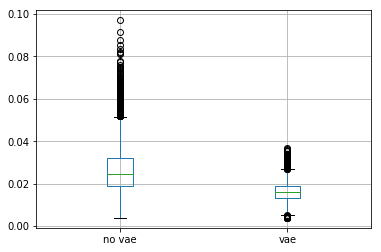

In [16]:
# Plot distribution of variances using no shifted data and shifted data
boxplot = df_vae.boxplot(column=['no vae', 'vae'])

**Conclusions**:
Based on the results it looks like there is some shrinkage of the variance using the VAE. This is expected given the assumption that the VAE is making for latent space features to draw from a standard Normal distribution. Without this constraint, there are sparse regions in the latent space (i.e. the space is not continuous) that make generating relalistic 
data from these regions difficult because there is no information about this space. Therefore, this constraint was added ontop of the generic autoencoder (AE) in order to reduce the variance in the latent space to ensure a continuous latent space. Thus we would expect the VAE to squish the variance of the original data.


Some references:
- https://arxiv.org/abs/1312.6114
- https://towardsdatascience.com/intuitively-understanding-variational-autoencoders-1bfe67eb5daf